In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
import joblib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tqdm import tqdm
import math

In [4]:
df = pd.read_csv("AAPL.csv", parse_dates=["Date"])
df = df.sort_values("Date").reset_index(drop=True)
df = df[["Date", "Close"]].dropna()
df.head()

,Date,Close
0,2005-10-17,6.60
1,2005-10-18,6.45
2,2005-10-19,6.78
3,2005-10-20,6.93
4,2005-10-21,6.87


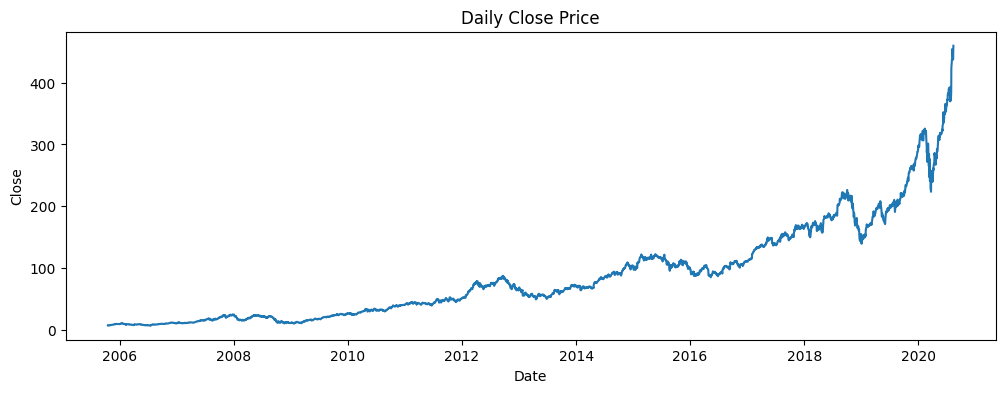

In [5]:
plt.figure(figsize=(12,4))
plt.plot(df.Date, df.Close)
plt.title("Daily Close Price")
plt.xlabel("Date")
plt.ylabel("Close")
plt.show()


In [6]:
def train_val_test_split_by_date(df, val_size=0.1, test_size=0.1):
    n = len(df)
    test_n = int(n * test_size)
    val_n = int(n * val_size)
    train = df.iloc[: n - val_n - test_n].copy()
    val = df.iloc[n - val_n - test_n: n - test_n].copy()
    test = df.iloc[n - test_n:].copy()
    return train, val, test

def scale_series(train_series, val_series=None, test_series=None):
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_series.values.reshape(-1,1)).flatten()
    result = {'scaler': scaler, 'train': train_scaled}
    if val_series is not None:
        result['val'] = scaler.transform(val_series.values.reshape(-1,1)).flatten()
    if test_series is not None:
        result['test'] = scaler.transform(test_series.values.reshape(-1,1)).flatten()
    return result

In [7]:
def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    # sklearn's MAPE expects non-zero y_true; add tiny epsilon to avoid division by zero
    return mean_absolute_percentage_error(y_true, y_pred)

In [8]:
def rolling_forecast(df_dates, series, model_forecast_func, window_size, horizon, step=1):
    """
    df_dates: list/dates (for indexing)
    series: 1D np.array of the full series (unscaled or scaled — be consistent)
    model_forecast_func: function(history_array, horizon) -> forecast_array (length=horizon)
    window_size: number of points used for fitting each step
    horizon: forecast horizon
    step: sliding step
    Returns: dict with predictions, truths, indices
    """
    preds = []
    truths = []
    indices = []  # index of start of truth
    n = len(series)
    # we forecast for times where we have at least window_size history and horizon future
    start = window_size
    end = n - horizon + 1
    for t in range(start, end, step):
        history = series[t-window_size:t]
        y_true = series[t:t+horizon]
        y_pred = model_forecast_func(history, horizon)
        preds.append(y_pred)
        truths.append(y_true)
        indices.append(t)
    preds = np.array(preds)
    truths = np.array(truths)
    return {'preds': preds, 'truths': truths, 'indices': indices}


In [9]:
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import warnings
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.filterwarnings("ignore")

def arima_forecast(history, horizon, order=(5,1,0)):
    # history: 1D numpy array (not scaled inverse needed outside)
    try:
        model = ARIMA(history, order=order)
        model_fit = model.fit()
        fc = model_fit.forecast(steps=horizon)
        return np.array(fc)
    except Exception as e:
        # fallback: naive persistence (last value)
        last = history[-1]
        return np.array([last]*horizon)

In [10]:
def create_sequences(arr, seq_len=30, horizon=1):
    X, y = [], []
    for i in range(len(arr) - seq_len - horizon + 1):
        X.append(arr[i:i+seq_len])
        y.append(arr[i+seq_len:i+seq_len+horizon])
    X = np.array(X)
    y = np.array(y)
    # reshape X for LSTM: (samples, seq_len, features)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    return X, y

def build_lstm(seq_len=30, horizon=1, hidden_units=64, dropout=0.1):
    model = Sequential([
        LSTM(hidden_units, input_shape=(seq_len,1)),
        Dropout(dropout),
        Dense(horizon)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [11]:
def lstm_forecast(history, horizon, seq_len=30, epochs=50, verbose=0):
    """
    history: 1D numpy array (scaled between 0-1 ideally)
    We'll use the last portion of history to create training sequences.
    For speed in rolling eval, reduce epochs like 5-20.
    """
    if len(history) < seq_len + horizon + 1:
        # fallback to persistence
        last = history[-1]
        return np.array([last]*horizon)
    X, y = create_sequences(history, seq_len=seq_len, horizon=horizon)
    # if only one sample, fallback
    if X.shape[0] < 5:
        # not enough data to train; return persistence
        return np.array([history[-1]]*horizon)
    model = build_lstm(seq_len=seq_len, horizon=horizon, hidden_units=64)
    # early stop lightly
    model.fit(X, y, epochs=epochs, batch_size=16, verbose=verbose)
    # prepare input: last seq_len values
    input_seq = history[-seq_len:].reshape((1, seq_len, 1))
    pred = model.predict(input_seq, verbose=0).flatten()
    return pred


In [12]:
train, val, test = train_val_test_split_by_date(df, val_size=0.1, test_size=0.1)
full_series = df['Close'].values
dates = df['Date'].values

# scaler fit on train
scaler = MinMaxScaler()
scaler.fit(train[['Close']])
full_scaled = scaler.transform(df[['Close']]).flatten()

# define indices for test start
test_start_idx = df.index[df['Date'] == test['Date'].iloc[0]][0]
print("test starts at index", test_start_idx)


test starts at index 3359


In [13]:
window_size = 252
horizon = 5
step = 5  # slide every 5 days to reduce compute

# ARIMA rolling (on original scale)
def arima_wrapper(history, horizon):
    return arima_forecast(history, horizon, order=(5,1,0))

res_arima = rolling_forecast(dates, full_series, arima_wrapper, window_size=window_size, horizon=horizon, step=step)

# LSTM rolling (on scaled scale)
def lstm_wrapper_scaled(history, horizon):
    # history comes scaled here
    pred_scaled = lstm_forecast(history, horizon, seq_len=30, epochs=10, verbose=0)
    # inverse scale predictions before returning (history was scaled w/ scaler fitted earlier)
    pred_scaled = np.array(pred_scaled)
    # inverse transform: need reshape
    pred_inv = scaler.inverse_transform(pred_scaled.reshape(-1,1)).flatten()
    return pred_inv

# But rolling_forecast expects one series. We'll feed scaled but keep mapping.
res_lstm = rolling_forecast(dates, full_scaled,
                            model_forecast_func=lambda h, fw: scaler.inverse_transform(lstm_forecast(h, fw, seq_len=30, epochs=10, verbose=0).reshape(-1,1)).flatten(),
                            window_size=window_size,
                            horizon=horizon,
                            step=step)

In [14]:
def evaluate_rolling(result, series, indices, horizon, test_start_idx):
    preds = result['preds']
    truths = result['truths']
    idxs = result['indices']
    # collect only forecasts whose first predicted index >= test_start_idx
    rows = []
    for i, idx in enumerate(idxs):
        if idx >= test_start_idx:
            y_true = truths[i]
            y_pred = preds[i]
            rows.append((idx, y_true, y_pred))
    if not rows:
        raise ValueError("No test windows selected, adjust window/horizon/step or check splits.")
    # flatten and compute metrics for each horizon-step aggregated
    y_true_flat = np.concatenate([r[1] for r in rows])
    y_pred_flat = np.concatenate([r[2] for r in rows])
    return {'RMSE': rmse(y_true_flat, y_pred_flat), 'MAPE': mape(y_true_flat, y_pred_flat)}

arima_metrics = evaluate_rolling(res_arima, full_series, res_arima['indices'], horizon, test_start_idx)
lstm_metrics = evaluate_rolling(res_lstm, full_series, res_lstm['indices'], horizon, test_start_idx)
print("ARIMA:", arima_metrics)
print("LSTM:", lstm_metrics)

ARIMA: {'RMSE': 10.558241430720086, 'MAPE': 0.024146145567999763}
LSTM: {'RMSE': 244.66744217564593, 'MAPE': 143.10247144923565}


In [15]:
import pandas as pd
metrics_df = pd.DataFrame([{
    'Model': 'ARIMA(5,1,0)',
    'RMSE': arima_metrics['RMSE'],
    'MAPE': arima_metrics['MAPE']
},{
    'Model': 'LSTM (seq=30, epochs=10)',
    'RMSE': lstm_metrics['RMSE'],
    'MAPE': lstm_metrics['MAPE']
}])
metrics_df

,Model,RMSE,MAPE
0,"ARIMA(5,1,0)",10.558241,0.024146
1,"LSTM (seq=30, epochs=10)",244.667442,143.102471


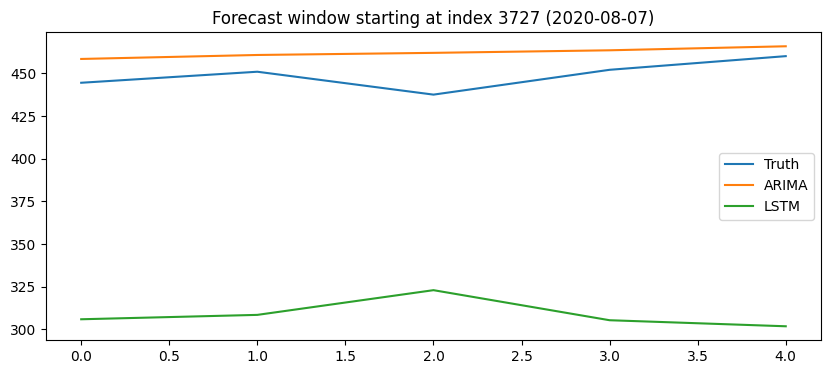

In [16]:
i = -1
# find a test window index (last one)
for j, idx in enumerate(res_arima['indices']):
    if idx >= test_start_idx:
        i = j
# choose that i
plt.figure(figsize=(10,4))
truth = res_arima['truths'][i]
pred_a = res_arima['preds'][i]
pred_l = res_lstm['preds'][i]
x = np.arange(len(truth))
plt.plot(x, truth, label='Truth')
plt.plot(x, pred_a, label='ARIMA')
plt.plot(x, pred_l, label='LSTM')
plt.legend()
plt.title(f'Forecast window starting at index {res_arima["indices"][i]} ({df.Date.iloc[res_arima["indices"][i]].date()})')
plt.show()

# DataSynthis ML JobTask

This repository contains the code and artifacts for the DataSynthis ML JobTask.

## Models

- ARIMA(5,1,0)
- LSTM (seq=30, epochs=10)

## Artifacts

- `scaler.joblib`: MinMaxScaler fitted on the training data.